In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os

# display images
from torchvision import utils
# import matplotlib.pyplot as plt
# %matplotlib inline

# utils
import numpy as np
# from torchsummary import summary
import time
import copy

import torchOptics.optics as tt
import warnings
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}

In [2]:
!nvidia-smi

Sun Mar 24 16:24:53 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:67:00.0 Off |                  N/A |
|  0%   21C    P8    29W / 350W |    254MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
gc.collect()
torch.cuda.empty_cache()

NameError: name 'gc' is not defined

In [4]:
import torch.nn.functional as F
import torchvision
import glob
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.resize = torchvision.transforms.CenterCrop(512)

    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray = True)
        # print(target.shape)
        target = target.unsqueeze(0)
        target = self.resize(target)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'

# target_dir = '512dataset/artwork/'
# valid_dir = '512dataset/dishes/'

meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir = target_dir, meta = meta)
valid_dataset = Dataset512(target_dir = valid_dir, meta = meta)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [5]:
len(train_dataset)

800

In [6]:
len(valid_dataset)

100

In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc

class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BasicBlock, self).__init__()
        # self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(x))
        # out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class TransitionDownBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionDownBlock, self).__init__()
        # self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
        self.pooling = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=2, padding=1)
    def forward(self, x):
        out = self.conv1(self.relu(x))
        # out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return self.pooling(out)

class TransitionUpBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionUpBlock, self).__init__()
        inter_planes = out_planes*4
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.unpool = nn.ConvTranspose2d(inter_planes, inter_planes, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
    def forward(self, x):
        out = self.relu(self.conv1(x))
        # out = self.unpool(out, output_size=out.size())
        out = self.unpool(out)
        out = self.relu(self.conv2(out))
        return out
        
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNet3(nn.Module):
    def __init__(self, depth, growth_rate=16,
                 reduction=0.5, bottleneck=True, dropRate=0.0, num_hologram=1):
        super(DenseNet3, self).__init__()
        in_planes = 2 * growth_rate
        block = BasicBlock
        n = depth
        channel_list = []
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(1, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)  # 1 > 2*growth_rate = 32 # 2048>1024
        self.pool1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=2, padding=1)
        # 1 for grayscale
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate) 
        in_planes = int(in_planes+n*growth_rate)  # 32 > 32+3*16 = 80
        channel_list.append(in_planes)
        self.trans1 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 1024>512
        in_planes = int(math.floor(in_planes*reduction))  # 80 > 80*0.5 = 40
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans2 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans3 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 4th block
        self.block4 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans4 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 5th block
        self.block5 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        channel_list.append(in_planes)
        self.trans5 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
                                          dropRate=dropRate)  # 512>256
        in_planes = int(math.floor(in_planes*reduction))  # 88 > 44
        # 6th block
        # self.block6 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        # in_planes = int(in_planes+n*growth_rate)  # 40 > 88
        # self.trans6 = TransitionDownBlock(in_planes, int(math.floor(in_planes*reduction)), 
        #                                   dropRate=dropRate)  # 512>256
        # in_planes = int(math.floor(in_planes*reduction))  # 88 > 44

        # 7th block
        self.block7 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)  # 44 > 92
        
        # # 8th block
        # self.trans8 = TransitionUpBlock(in_planes, int(math.floor(in_planes*reduction)),
        #                                 dropRate=dropRate)  # 256>512
        # in_planes = int(math.floor(in_planes*reduction)) 
        # self.block8 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        # in_planes = int(in_planes+n*growth_rate)
        # 9th block
        self.trans9 = TransitionUpBlock(in_planes, channel_list[4],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction))
        self.block9 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 10th block
        self.trans10 = TransitionUpBlock(channel_list[4], channel_list[3],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction))
        in_planes = channel_list[3]
        self.block10 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 11th block
        self.trans11 = TransitionUpBlock(channel_list[3], channel_list[2],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction))
        in_planes = channel_list[2]
        self.block11 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 12th block
        self.trans12 = TransitionUpBlock(channel_list[2], channel_list[1],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction)) 
        in_planes = channel_list[1]
        self.block12 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)
        # 13th block
        self.trans13 = TransitionUpBlock(channel_list[1], channel_list[0],
                                        dropRate=dropRate)  # 512>1024
        # in_planes = int(math.floor(in_planes*reduction)) 
        in_planes = channel_list[0]
        self.block13 = DenseBlock(n, in_planes*2, growth_rate, block, dropRate)
        in_planes = int(2*in_planes+n*growth_rate)

        self.conv2 = nn.Conv2d(channel_list[0], 16, kernel_size=3, stride=1, padding=1)
        self.unpool = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.conv3= nn.Conv2d(16, num_hologram, kernel_size=1, stride=1,
                               bias=False)
        
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        # self.fc = nn.Linear(in_planes, num_classes)
        
        self.sign_function = SignFunction.apply
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        # print(x.shape)
        out = self.conv1(x)
        out = self.pool1(out)
        out1_1 = self.block1(out)
        # print(out1_1.shape)
        out1_2 = self.trans1(out1_1)
        # print(out1_2.shape)
        out2_1 = self.block2(out1_2)
        # print(out2_1.shape)
        out2_2 = self.trans2(out2_1)
        # print(out2_2.shape)
        out3_1 = self.block3(out2_2)
        # print(out3_1.shape)
        out3_2 = self.trans3(out3_1)
        # print(out3_2.shape)
        out4_1 = self.block4(out3_2)
        # print(out4_1.shape)
        out4_2 = self.trans4(out4_1)
        # print(out4_2.shape)
        out5_1 = self.block5(out4_2)
        # print(out5_1.shape)
        out5_2 = self.trans5(out5_1)
        # print(out5_2.shape)
        del out1_2, out2_2, out3_2, out4_2
        out7 = self.block7(out5_2)
        # print(out7.shape)
        del out5_2
        out9_1 = self.trans9(out7)
        # print(out9_1.shape)
        
        # out9_2 = self.block9(torch.cat([out5_1, out9_1], dim=1))
        
        # print(out9_2.shape)
        # print(out5_1.shape, out9_1.shape, out9_2.shape)
        out10_1 = self.trans10(out9_1 + out5_1)
        # print(out10_1.shape)
        del out9_1
        # print(out4_1.shape, out10_1.shape, out9_2.shape)
        # out10_2 = self.block10(torch.cat([out4_1, out10_1], dim=1))
        # print(out10_2.shape)
        out11_1 = self.trans11(out10_1 + out4_1)
        del out10_1
        # out11_2 = self.block11(torch.cat([out3_1, out11_1], dim=1))
        # print(out11_2.shape)
        out12_1 = self.trans12(out11_1 + out3_1)
        # print(out12_1.shape)
        del out11_1
        gc.collect()
        torch.cuda.empty_cache()
        # out12_2 = self.block12(torch.cat([out2_1, out12_1], dim=1))
        out13_1 = self.trans13(out12_1 + out2_1)
        # print(out13_1.shape)
        del out12_1
        torch.cuda.empty_cache()
        # out13_2 = self.block13(torch.cat([out1_1, out13_1], dim=1))
        out = out13_1 + out1_1
        # print(out.shape)
        out = self.conv2(out)
        # print(out.shape)
        out = self.unpool(out)
        # print(out.shape)
        out = self.conv3(out)
        # print(out.shape)
        gc.collect()
        torch.cuda.empty_cache()

        out = torch.nn.Tanh()(out)
        out = self.sign_function(out)
        return out

In [8]:
# !pip install torchsummary
model = DenseNet3(depth=3, dropRate=0.3, num_hologram=1).to('cuda')
output = model(valid_dataset[0].unsqueeze(0))
output.shape

torch.Size([1, 1, 512, 512])

In [9]:
from torchsummary import summary
with torch.no_grad():
    model = DenseNet3(depth=3, dropRate=0.3, num_hologram=1).to('cuda')
    summary(model, (1,512,512))

ModuleNotFoundError: No module named 'torchsummary'

In [12]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torchOptics.metrics as tm
import tqdm as tqdm
# writer = SummaryWriter()
writer = SummaryWriter()
num_hologram = 10
lr = 1e-5
depth = 3
dropRate = 0.3
model = DenseNet3(depth=depth, dropRate=dropRate, num_hologram=num_hologram)
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sign_function = SignFunction.apply
epochs = 100
z = 2e-3
path = 'models/'
criterion = nn.MSELoss()
# valid_image = valid_dataset[0]
writer.add_scalar("num_hologram", num_hologram)
writer.add_scalar("learning_rata", lr)
writer.add_scalar("depth", depth)
writer.add_scalar("dropRate", dropRate)
writer.add_scalar("z", z)
model_idx = 1
while os.path.isfile(path+f'densenet{model_idx}_binary_240321.pt'):
    model_idx += 1
    
for epoch in range(epochs):
    pbar = tqdm.tqdm(trainloader)
    model.train()
    for target in pbar:
        out = model(target)
        sim = tt.simulate(out, z).abs()**2
        result = torch.mean(sim, dim=1, keepdim=True)
        loss = tt.relativeLoss(result, target, F.mse_loss)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        psnrList = []
        mseList = []
        for valid in validloader:
            out = model(valid)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
            psnrList.append(psnr)
            mse = tt.relativeLoss(result, valid, F.mse_loss)
            mseList.append(mse)
        mean_psnr = sum(psnrList)/len(psnrList)
        mean_mse = sum(mseList)/len(mseList)
        writer.add_scalar("mean_PSNR/valid", mean_psnr, epoch)
        writer.add_scalar("mean_MSE/valid", mean_mse, epoch)
        print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
        print(f'mean MSE : {mean_mse} {epoch}/{epochs}')
    # print(f'------ valid : Epoch {epoch:4d}/{epochs} MSE : {valid_loss.item():.6f}')
    torch.save(model, path + f'densenet{model_idx}_binary_240324_333_test.pt')
writer.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:20<00:00,  3.08it/s]


mean PSNR : 17.37409614562988 0/100
mean MSE : 0.01872309483587742 0/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 18.588028535842895 1/100
mean MSE : 0.0145204346626997 1/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 19.39311529159546 2/100
mean MSE : 0.012178197503089905 2/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 19.90717195510864 3/100
mean MSE : 0.010938641615211964 3/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:23<00:00,  3.03it/s]


mean PSNR : 20.342352151870728 4/100
mean MSE : 0.009922808967530727 4/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 20.753727979660034 5/100
mean MSE : 0.009140445850789547 5/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:44<00:00,  2.81it/s]


mean PSNR : 20.903785791397095 6/100
mean MSE : 0.00881997775286436 6/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [05:49<00:00,  2.29it/s]


mean PSNR : 21.097815971374512 7/100
mean MSE : 0.008468965999782085 7/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 21.28565581321716 8/100
mean MSE : 0.008156192488968372 8/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 21.659567832946777 9/100
mean MSE : 0.007586950436234474 9/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:20<00:00,  2.10it/s]


mean PSNR : 21.818512420654297 10/100
mean MSE : 0.007330568972975016 10/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 21.945400733947753 11/100
mean MSE : 0.0071280598640441895 11/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.09it/s]


mean PSNR : 22.047375869750976 12/100
mean MSE : 0.006980577949434519 12/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 22.098441896438597 13/100
mean MSE : 0.006889910437166691 13/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:23<00:00,  2.09it/s]


mean PSNR : 22.110387878417967 14/100
mean MSE : 0.00685444800183177 14/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 22.251573429107665 15/100
mean MSE : 0.006680264137685299 15/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 22.30784755706787 16/100
mean MSE : 0.006605660542845726 16/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:20<00:00,  2.10it/s]


mean PSNR : 22.389634199142456 17/100
mean MSE : 0.006505779922008514 17/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.09it/s]


mean PSNR : 22.448331050872802 18/100
mean MSE : 0.006416364572942257 18/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 22.499641981124878 19/100
mean MSE : 0.006348612252622843 19/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:20<00:00,  2.10it/s]


mean PSNR : 22.562831287384032 20/100
mean MSE : 0.0062659019604325294 20/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:23<00:00,  2.09it/s]


mean PSNR : 22.64608804702759 21/100
mean MSE : 0.006168324965983629 21/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:20<00:00,  2.10it/s]


mean PSNR : 22.7170711517334 22/100
mean MSE : 0.006085847970098257 22/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 22.746423768997193 23/100
mean MSE : 0.006045656278729439 23/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 22.781138734817503 24/100
mean MSE : 0.006001889705657959 24/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 22.823923416137696 25/100
mean MSE : 0.005944433622062206 25/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 22.833374376296998 26/100
mean MSE : 0.005920152645558119 26/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 22.847996673583985 27/100
mean MSE : 0.005894629284739494 27/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 22.881381216049196 28/100
mean MSE : 0.005842533428221941 28/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:23<00:00,  2.09it/s]


mean PSNR : 22.94098937988281 29/100
mean MSE : 0.005773262120783329 29/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 22.961633453369142 30/100
mean MSE : 0.00574343791231513 30/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:21<00:00,  2.10it/s]


mean PSNR : 22.99217279434204 31/100
mean MSE : 0.005702289752662182 31/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:22<00:00,  2.09it/s]


mean PSNR : 23.03835690498352 32/100
mean MSE : 0.005650272127240896 32/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:23<00:00,  2.09it/s]


mean PSNR : 23.039771327972414 33/100
mean MSE : 0.005631998181343079 33/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [06:18<00:00,  2.11it/s]


mean PSNR : 23.042014265060423 34/100
mean MSE : 0.0056217387318611145 34/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [05:41<00:00,  2.35it/s]


mean PSNR : 23.092477407455444 35/100
mean MSE : 0.005565132480114698 35/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [05:41<00:00,  2.34it/s]


mean PSNR : 23.1058288192749 36/100
mean MSE : 0.005536355078220367 36/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [05:41<00:00,  2.34it/s]


mean PSNR : 23.11826835632324 37/100
mean MSE : 0.005523013416677713 37/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [05:41<00:00,  2.34it/s]


mean PSNR : 23.108514165878297 38/100
mean MSE : 0.005524486303329468 38/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [05:41<00:00,  2.34it/s]


mean PSNR : 23.144767227172853 39/100
mean MSE : 0.005481186788529158 39/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [05:11<00:00,  2.57it/s]


mean PSNR : 23.23209840774536 40/100
mean MSE : 0.0053890966810286045 40/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:37<00:00,  2.88it/s]


mean PSNR : 23.234714803695677 41/100
mean MSE : 0.00537357572466135 41/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.237499141693114 42/100
mean MSE : 0.0053622303530573845 42/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.21492546081543 43/100
mean MSE : 0.005373678635805845 43/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.07it/s]


mean PSNR : 23.288818035125733 44/100
mean MSE : 0.00529667129740119 44/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.236203746795653 45/100
mean MSE : 0.005341900046914816 45/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.263078632354738 46/100
mean MSE : 0.005302042234688997 46/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.21523036003113 47/100
mean MSE : 0.0053426180966198444 47/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.28895604133606 48/100
mean MSE : 0.00526476139202714 48/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.26708249092102 49/100
mean MSE : 0.005273914895951748 49/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.249781589508057 50/100
mean MSE : 0.00528462091460824 50/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:20<00:00,  3.07it/s]


mean PSNR : 23.262793245315553 51/100
mean MSE : 0.0052654133178293705 51/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.3559659576416 52/100
mean MSE : 0.005177909508347511 52/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.04it/s]


mean PSNR : 23.269449348449708 53/100
mean MSE : 0.005245758220553398 53/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.2841832447052 54/100
mean MSE : 0.005229155998677015 54/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.24542423248291 55/100
mean MSE : 0.005261960439383984 55/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.229932403564455 56/100
mean MSE : 0.005254356190562248 56/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.05it/s]


mean PSNR : 23.336687126159667 57/100
mean MSE : 0.005167713854461908 57/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.367537326812744 58/100
mean MSE : 0.005122254602611065 58/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.223766021728515 59/100
mean MSE : 0.005266939755529165 59/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.293193302154542 60/100
mean MSE : 0.00518924230709672 60/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.338137483596803 61/100
mean MSE : 0.005149499513208866 61/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.359396686553954 62/100
mean MSE : 0.0051119509153068066 62/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.35942777633667 63/100
mean MSE : 0.0051192305982112885 63/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.39685400009155 64/100
mean MSE : 0.005072647240012884 64/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.281229219436646 65/100
mean MSE : 0.005171480122953653 65/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.31095911026001 66/100
mean MSE : 0.005138583481311798 66/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.444190273284914 67/100
mean MSE : 0.0050138202495872974 67/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.438114204406737 68/100
mean MSE : 0.005021510645747185 68/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.04it/s]


mean PSNR : 23.358725471496584 69/100
mean MSE : 0.005087473429739475 69/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.425318508148194 70/100
mean MSE : 0.005031262524425983 70/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.35966260910034 71/100
mean MSE : 0.005087233614176512 71/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.40456732749939 72/100
mean MSE : 0.005046679172664881 72/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.401086301803588 73/100
mean MSE : 0.005031268578022718 73/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.316128730773926 74/100
mean MSE : 0.005110573023557663 74/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.42025712966919 75/100
mean MSE : 0.005022846162319183 75/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.326018476486205 76/100
mean MSE : 0.005088131874799728 76/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.48371072769165 77/100
mean MSE : 0.004950179718434811 77/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.488742971420287 78/100
mean MSE : 0.004941714461892843 78/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.05it/s]


mean PSNR : 23.414678382873536 79/100
mean MSE : 0.005006246268749237 79/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.489038524627684 80/100
mean MSE : 0.004948630928993225 80/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:24<00:00,  3.02it/s]


mean PSNR : 23.500328273773192 81/100
mean MSE : 0.004940686281770468 81/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.399017944335938 82/100
mean MSE : 0.005024841520935297 82/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.05it/s]


mean PSNR : 23.525107069015505 83/100
mean MSE : 0.004891570191830397 83/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:23<00:00,  3.04it/s]


mean PSNR : 23.48774983406067 84/100
mean MSE : 0.004933339077979326 84/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.57901586532593 85/100
mean MSE : 0.004849091172218323 85/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.626441068649292 86/100
mean MSE : 0.004816777538508177 86/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.53701376914978 87/100
mean MSE : 0.004891092423349619 87/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.582091836929322 88/100
mean MSE : 0.004854212515056133 88/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.512047672271727 89/100
mean MSE : 0.004904655274003744 89/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.49198130607605 90/100
mean MSE : 0.0049230847507715225 90/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.05it/s]


mean PSNR : 23.572099504470824 91/100
mean MSE : 0.004852411802858114 91/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.05it/s]


mean PSNR : 23.534344577789305 92/100
mean MSE : 0.004871590528637171 92/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.55216975212097 93/100
mean MSE : 0.004851603880524635 93/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:24<00:00,  3.03it/s]


mean PSNR : 23.571811275482176 94/100
mean MSE : 0.0048355055041611195 94/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:23<00:00,  3.04it/s]


mean PSNR : 23.465352573394775 95/100
mean MSE : 0.0049375868402421474 95/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.452719345092774 96/100
mean MSE : 0.004939444828778505 96/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.56865037918091 97/100
mean MSE : 0.004833264742046595 97/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:22<00:00,  3.05it/s]


mean PSNR : 23.555642290115358 98/100
mean MSE : 0.004840397741645575 98/100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [04:21<00:00,  3.06it/s]


mean PSNR : 23.55115972518921 99/100
mean MSE : 0.004845102783292532 99/100


In [13]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [14]:
model = torch.load('models/densenet3_binary_240324_333_test.pt')


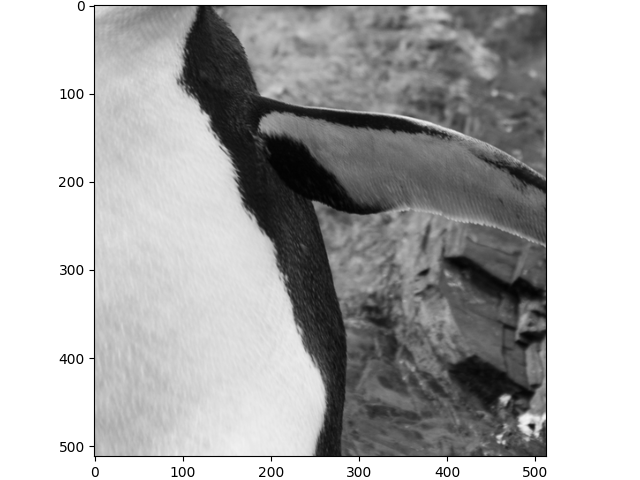

In [15]:
tt.show(valid_dataset[0])

In [19]:
import torchOptics.metrics as tm
valid = valid_dataset[-1].unsqueeze(0)
sign_function = SignFunction.apply
z = 0
with torch.no_grad():
    out = model(valid)
    binary = sign_function(out)
    sim = tt.simulate(binary, z).abs()**2
    result = torch.mean(sim, dim=1, keepdim=True)
    psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
    # psnrList.append(psnr)
    mse = tt.relativeLoss(result, valid, F.mse_loss)
    # mseList.append(mse)


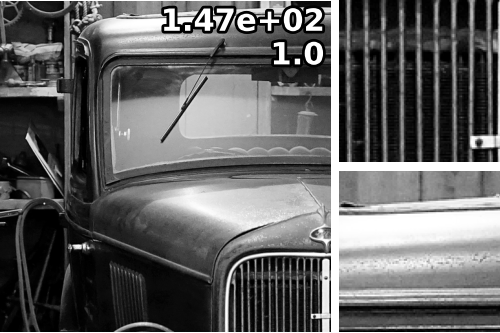

In [20]:
tt.show_with_insets(valid,valid)


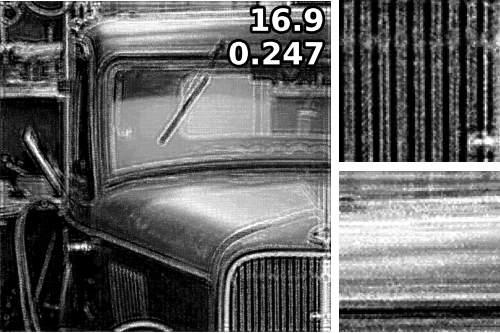

In [21]:
tt.show_with_insets(result, valid)

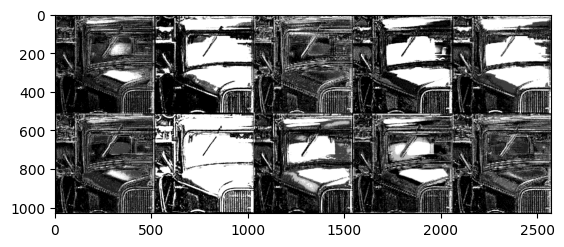

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [22]:
binary

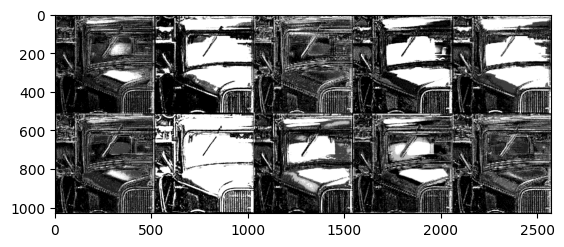

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [23]:
out